# 3 vs 4 sided boom on ARCUS

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import print_function, division
import sys
import numpy as np
from mayavi import mlab
from astropy.coordinates import SkyCoord
import marxs
from marxs import visualization
from marxs.visualization.mayavi import plot_object, plot_rays

from marxs.source import PointSource, FixedPointing, JitterPointing

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Add location of arcus definitions to path (unless in same directory).
# Not found automatically, because I did not install it as a module.
sys.path.append('..')
import arcus.arcus
import arcus.boom

In [24]:
print('MARXS version', marxs.__version__)
print('ARCUS commit hash: c857a75')  # looked up by hand.

MARXS version 1.1.dev559
ARCUS commit hash: c857a75


## Geometry



In [4]:
# origin of coordinate system is one of the focal points.
# center boom around mid-point between the two focal points.
boompos = [1000., arcus.arcus.d, 0]

In [5]:
angles = np.arange(0, 2. * np.pi/3., 0.1)
l_batten = np.array([1.6, 1.8, 2.0, 2.25, 2.5, 2.75]) * 1e3
colors = ['k', 'b', 'r', 'g', 'm', '0.6']

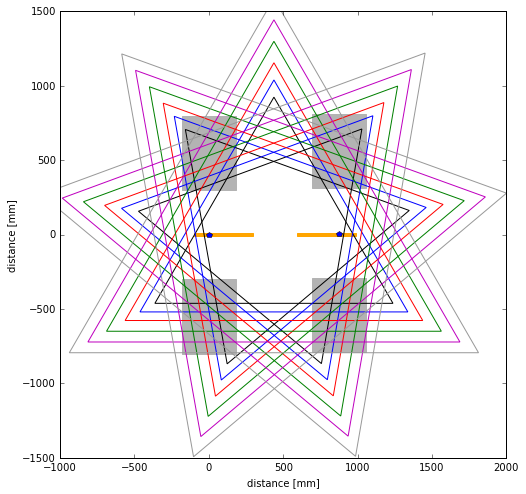

In [6]:
import matplotlib.patches as patches
from transforms3d.affines import decompose

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal')

for e in arcus.arcus.aper4.elements:
    trans, rot, zoom, shear = decompose(e.pos4d)
    aper = patches.Rectangle(trans[1:] - zoom[1:], zoom[1] * 2, zoom[2] * 2, 
                             linewidth=1, edgecolor='0.7', facecolor='0.7', label='SPO')
    ax.add_patch(aper)
for e in arcus.arcus.det_16.elements:
    trans, rot, zoom, shear = decompose(e.pos4d)
    det = patches.Rectangle(trans[1:] - zoom[1:], zoom[1] * 2, zoom[2] * 2, 
                             linewidth=1, edgecolor='orange', facecolor='orange', label='detector')
    ax.add_patch(det)
    
for i in range(len(l_batten)):
    for a in angles[::7]:
        triag = patches.RegularPolygon(boompos[1:], 3, l_batten[i] * 3**(-0.5), a, 
                                       edgecolor=colors[i], linewidth=1, facecolor='none',
                                       label='boom')
        ax.add_patch(triag)
optax = plt.plot([0, 2 * arcus.arcus.d], 
                 [-arcus.arcus.z_offset_spectra, arcus.arcus.z_offset_spectra],
                 'p', label='opt. axis')
ax.set_ylim([-1.5e3, 1.5e3])
ax.set_xlim([-1e3, 2.e3])
ax.set_xlabel('distance [mm]')
out = ax.set_ylabel('distance [mm]')

The plot above shows a view along the optical axis. The gray boxes are the entrace apertures that are filled with SPOs, the small orange rectangles along the y=0 axis are the 16 CCDs (set in two groups of 8). Remember that in the current layout we have two pairs of SPO channels, where each pair has its own optical axis. This allows us to place the CCD detectors in such a way that we catch the zeroths order for each pair as well as the dispersed spectrum in the region where the CAT gratings cast most of the signal.

The left pair of SPO modules focusses on the left blue pentagon, so zeroth order rays from the left pair of SPOs will be located there. The dispersed spectrum is imaged on the right detector strip. Conversely, the right pair of SPO channels places its zeroth order on the right blue pentagon and the dispersed photons on the left detector strip. 

Overlayed are several triangles marking the footprint of a three-sided boom with different dimenions. The colors are the same as in thes figures in the next section, where the exact dimensions are given.
There are many ways to overlay a triangular boom on the rectangular geometry of the SPO channels. With changing rotation angle, rays going through different parts of the SPOs will have a chance of hitting the boom. The figure shows three possible configurationsw, but in the simulations below I use a much denser grid of rotation angles with a step size of just a few degrees.

The origin of the coordinate system in this plot is set on the left focal point.

## How does absorption depend on boom size and boom rotation angle?

In [7]:
n_photons = 1e5

# define position and spectrum of source
energy = np.arange(0.25, 1.7, .01)
mysource = PointSource(coords=SkyCoord(0., 0., unit='deg'),
                       energy={'energy': energy,
                               'flux': np.ones_like(energy)/energy**2},
                       flux=1.)
jitterpointing = JitterPointing(coords=SkyCoord(0., 0., unit='deg'),
                                jitter=arcus.arcus.jitter_sigma)
fixedpointing = FixedPointing(coords=SkyCoord(0., 0., unit='deg'))


photons = mysource.generate_photons(n_photons)
photons = jitterpointing(photons)
photons = arcus.arcus.arcus4(photons)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxs-1.1.dev559-py2.7-linux-x86_64.egg/marxs/math/polarization.py:123: RuntimeWarning: invalid value encountered in divide
  s = s / np.linalg.norm(s, axis=1)[:, None]


In this section I use a single simulation of $10^5$ rays with a flat input spectrum ("flat" here means
that bins of constant width in wavelength will give you a flat spectrum - see plot below). The details of the spectrum are not terribly 
important; the point is that the numbers below are not specific to a single energy, but represent the average over 
a range of energies. The analysis below is limited to the photons that actually make it onto a detector for the current configuration of 16 CCDs in two strips as above. Changing the detector layout would slightly change some of the numbers below.

I save the path that each rays takes in this simulation. Then, I look at different booms (different sizes and rotation angles) and check which of the photons would have interacted with each boom. 

Note that I have not yet integrated Dick Willingale's qsoft code into my simulations. In my current implementation, 
the reflection probability of a photon depends on the energy, but is the same for all SPOs, while in practice the
SPOs that are located at a larger radius will typically see larger indidence angels than the SPOs located at smaller
radii. The reflection probability on the mirror shells depends on the incidence angles and thus the relative importance of the the SPOs at different radii should changes with photon energy. This will be included in a future version of my simulations.


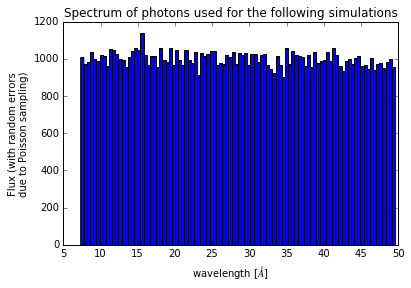

In [14]:
photons['wave'] = marxs.energy2wave / photons['energy'] * 1e7 # in ang
fig = plt.figure()
ax1 = fig.add_subplot(111)
out = ax1.hist(photons['wave'], bins=100)
ax1.set_xlabel('wavelength [$\AA$]')
ax1.set_ylabel('Flux (with random errors\ndue to Poisson sampling)')
out = ax1.set_title('Spectrum of photons used for the following simulations')

In [8]:
def boom_abs(photons, angles, boom_dims={}):
    hitrod = []

    for i, angle in enumerate(angles):
        rot = np.array([[1, 0, 0],
                        [0, np.cos(angle), -np.sin(angle)],
                        [0, np.sin(angle), np.cos(angle)]])
        myboom = arcus.boom.ThreeSidedBoom(orientation=rot, position=boompos, boom_dimensions=boom_dims)
        photons['hitrod'] = False
        photons = myboom(photons)
        hitrod.append(photons['hitrod'].copy())
    return hitrod


In [17]:
boom_hits = []
for l in l_batten:
    print('Working on l={}'.format(l))
    boom_hits.append(boom_abs(photons, angles, boom_dims={'l_batten': l}))

Working on l=1600.0
Working on l=1800.0
Working on l=2000.0
Working on l=2250.0
Working on l=2500.0
Working on l=2750.0


In [18]:
def calc_prob_matrix(ind):
    prob = np.empty((len(angles), len(l_batten)))
    for i in range(len(l_batten)):
        for j in range(len(angles)):
            prob[j, i] = photons['probability'][ind & boom_hits[i][j]].sum()
    return prob / photons['probability'][ind].sum()

In [19]:
ind = np.isfinite(photons['det_x'])
prob = calc_prob_matrix(ind)

n = np.mod(photons['spo'], 100)
inddownscopespo = ind & (n != 0) & (n!=5) & (n!=6) & (n!= 10)
prob2 = calc_prob_matrix(inddownscopespo)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


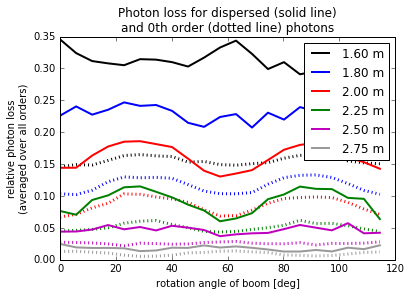

In [20]:
ind0 = ind & (photons['order'] == 0)
prob0 = calc_prob_matrix(ind0)

inddisp = ind & (photons['order'] < 0)
probdisp = calc_prob_matrix(inddisp)

fig = plt.figure()
ax = fig.add_subplot(111)

for i, l in enumerate(l_batten):
    ax.plot(np.rad2deg(angles), prob0[:, i], label='{:4.2f} m'.format(l / 1e3), color=colors[i], lw=2)
    ax.plot(np.rad2deg(angles), probdisp[:, i], label='__no_legend__', color=colors[i], ls=':', lw=3)
ax.legend()
ax.set_xlabel('rotation angle of boom [deg]')
ax.set_title('Photon loss for dispersed (solid line)\nand 0th order (dotted line) photons')
out = ax.set_ylabel('relative photon loss\n(averaged over all orders)')

The plot above shows which fraction of photons is lost due to hitting elements of the boom. Lines of different color are for different length of the battens (the boom structures running parallel to the focal plane). Solid lines are for the dispersed spectrum, dotted lines are for the zero order photons. For a 3-sided boom, a rotation of 120$^\circ$ maps the boom on itself, thus only the range up to 120$^\circ$ is shown.

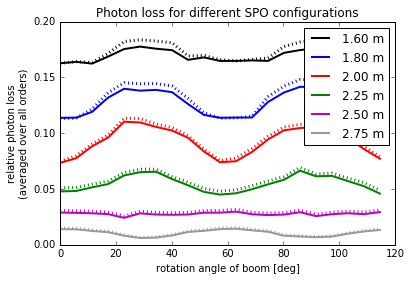

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ['k', 'b', 'r', 'g', 'm', '0.6']

for i, l in enumerate(l_batten):
    ax.plot(np.rad2deg(angles), prob[:, i], label='{:4.2f} m'.format(l / 1e3), color=colors[i], lw=2)
    ax.plot(np.rad2deg(angles), prob2[:, i], label='__no_legend__', color=colors[i], ls=':', lw=3)
ax.legend()
ax.set_xlabel('rotation angle of boom [deg]')
ax.set_title('Photon loss for different SPO configurations')
out = ax.set_ylabel('relative photon loss\n(averaged over all orders)')

This plot shows which fraction of photons is lost due to hitting elements of the boom including both zeroth order and dispersed photons. Lines of different color are for different length of the battens (the boom structures running parallel to the focal plane). Solid lines are for the the SPO configuration specified in the proposal; dotted lines are for a slightly downsized option where for each channel the four SPOs that have the largest angle to the centerline of the module are dropped (as Peter suggested to improve the PSF). They are located in column 1 and 6 of the first and second row in the SPO module (called row "2" and row "3" in the SPO layout document on our Google drive). 
Because the dropped SPOs are closest to the center, they are almost always *inside* the boom. Removing them reduces the number of unobstructed photons and thus the *fraction* of the total detected photons that is affected by the boom increases. That is why the dotted lines are all located slightly above the solid lines of the same color.

There are noticalbe differences with the boom rotation angle paticularly for intermediate boom sizes. For a small boom (black) essentially the entire circumfence of the boom is under the SPOs (see plot of the geometry above), while for very large booms only the outer corners of the SPO channel are touched by the boom. Thus, only a small fraction of photons is absobed independend of the rotation angle. For intermediate boom sizes with triangle edges around 2 m a clever choice or rotation angle can change the fraction of absorbed photons from 13% to 9%!

## Energy dependence

With the caveat in mind that the current mirror implementation does not simulate the angle dependence of the reflection probability in the SPOs and thus ignores that SPOs at different radius actually have a slightly different importance for different photon energies, we will now look at the photon losses as a function of photon energy. In the following, we will pick a particular orientation angle for the boom since the shape of the following plots differs only little with the rotation angle. Also, we will concentrate on the dispsered signal.

In [22]:
photons['wave'] = marxs.energy2wave / photons['energy'] * 1e7 # in ang

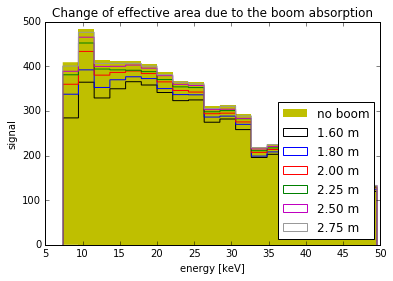

In [25]:
spec = plt.hist(photons['wave'][inddisp], 
                weights=photons['probability'][inddisp], bins=20,
                label='no boom', color='y', lw=0)
specabs = []
for i, l in enumerate(l_batten):
    indboom = boom_hits[i][0]
    specabs.append(plt.hist(photons['wave'][inddisp & ~indboom], 
                    weights=photons['probability'][inddisp & ~indboom], 
                       bins=outn[1],
                      histtype='step', color=colors[i],
                      label='{:4.2f} m'.format(l / 1e3)))

plt.xlabel('energy [keV]')
plt.ylabel('signal')
plt.title('Change of effective area due to the boom absorption')
out = plt.legend(loc='lower right')

The plot above gives the observed grating signal (with energy on the x-axis in this case). The input spectrum is flat, but the effective area has an energy dependence due to e.g. energy dependend reflection probabilities on the mirror, grating efficiency, filter curves of the optical blocking filter, detector gaps in the focal plane, CCD QE etc.
This plot shows us the *loss of effective area due to the boom*. Below, the same data is plotted again, but this time relative to the signal that would be detected in the absence of a boom.

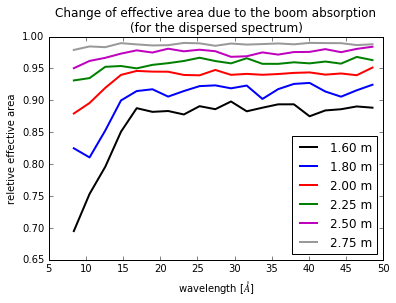

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

outn = np.histogram(photons['wave'][inddisp], bins=20)
outnabs = np.histogram(photons['wave'][inddisp & ~indboom], bins=outn[1])

spec = np.histogram(photons['wave'][inddisp], 
                weights=photons['probability'][inddisp], bins=outn[1])
specabs = []

for i, l in enumerate(l_batten):
    indboom = boom_hits[i][0]
    specabs.append(np.histogram(photons['wave'][inddisp & ~indboom], 
                    weights=photons['probability'][inddisp & ~indboom], 
                       bins=outn[1]))
    ax.plot(0.5 * (outn[1][:-1] + outn[1][1:]), 
            specabs[i][0] / spec[0],
            c=colors[i], lw=2,
            label='{:4.2f} m'.format(l / 1e3))

plt.xlabel('wavelength [$\AA$]')
plt.ylabel('reletive effective area')
plt.title('Change of effective area due to the boom absorption\n(for the dispersed spectrum)')
out = plt.legend(loc='lower right')

The plot above shows the change in effective area for booms of different size (fir a fixed orientation angle). Particualrly for small booms, the short wavelength end of the spectrum is hit hardest.

Last, we want to know if the absorption is smooth over the full wavelength range or if it produces line-like features that would be confused with an astrophysical signal. In particular, line-like features wold move with any boom movement or misalignment, so they should be avoided. **While the entire wavelength range should be check with simulations using a larger number of rays eventually**, I will just select some small regions here and zoom in to bin them to the ARCUS spectral resolving power. Also, I will only show the plot below for one particular boom (rotation = 0, fiducial size 1.6 m).

In [30]:
mysource = PointSource(coords=SkyCoord(0., 0., unit='deg'),
                       energy={'energy': np.array([0.65, 0.652]),
                               'flux': np.ones(2)}, flux=1.)
jitterpointing = JitterPointing(coords=SkyCoord(0., 0., unit='deg'),
                                jitter=arcus.arcus.jitter_sigma)
fixedpointing = FixedPointing(coords=SkyCoord(0., 0., unit='deg'))

myboom = arcus.boom.ThreeSidedBoom(position=boompos)

photonj = mysource.generate_photons(n_photons)
photonj = jitterpointing(photonj)
photonj = arcus.arcus.arcus4(photonj)
photonj = myboom(photonj)



NameError: name 'photonsj' is not defined

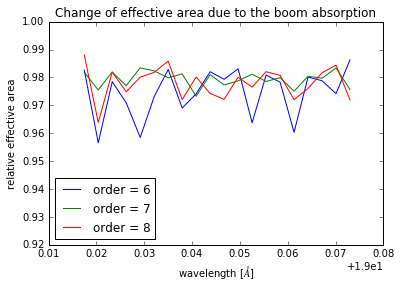

In [44]:
photonj['wave'] = marxs.energy2wave / photonj['energy'] * 1e7 # in ang

fig = plt.figure()
ax = fig.add_subplot(111)

indj = np.isfinite(photonj['det_x'])

for i in [-6, -7, -8]:
    indorder = photonj['order'] == i
    spec = np.histogram(photonj['wave'][indj & indorder], bins=20, 
                        weights=photonj['probability'][indj & indorder])
    specabs = np.histogram(photonj['wave'][indj & indorder & ~indboom], 
                       weights=photonj['probability'][indj & indorder & ~indboom], 
                       bins=spec[1])
    ax.plot(0.5 * (spec[1][:-1] + spec[1][1:]), specabs[0] / spec[0], label='order = {}'.format(int(np.abs(i))))


plt.xlabel('wavelength [$\AA$]')
plt.ylabel('relative effective area')
plt.title('Change of effective area due to the boom absorption')
plt.ylim([0.92, 1])
out = plt.legend(loc='lower left')

In the dispersed orders, the change in effective area looks relatively smooth. The wiggeling up and down in the plot is consistent with Poisson statistics. If we decide to continue to investigate this in more detail, I will run longer simulations with a larger number of photons, but for now, there are no indications that line-like features appear in the dispersed orders.